# First create the monolayer

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import tifffile as tiff
import skimage as sk
from copy import copy
import imageio, elasticdeform
from scipy.ndimage import gaussian_filter, zoom, rotate
import cv2

/tmp/ipykernel_1418549/629965164.py:8: RuntimeWarning: divide by zero encountered in divide
  z1 = -(0.8/np.sin(0.5*x))**2-(0.8/np.sin(0.5*y))**2+5
/tmp/ipykernel_1418549/629965164.py:9: RuntimeWarning: divide by zero encountered in divide
  z12 = (0.4/np.sin(0.5*x))**2+(0.4/np.sin(0.5*y))**2


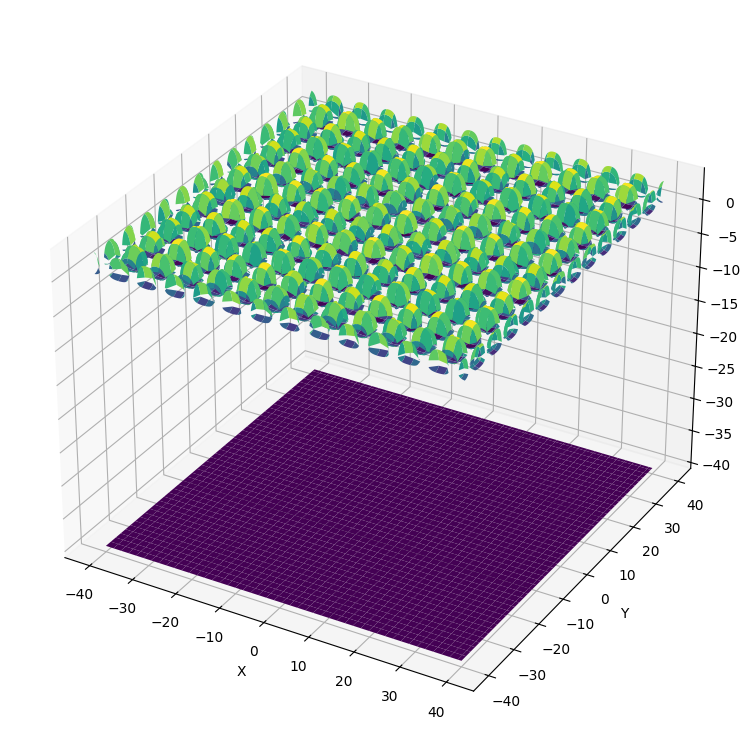

In [175]:
# Create a grid of x and y values
resolution = 500
size = 40
x = np.linspace(-size,  size,  resolution+1)
y = np.linspace(-size,  size,  resolution+1)
x, y = np.meshgrid(x, y)

z1 = -(0.8/np.sin(0.5*x))**2-(0.8/np.sin(0.5*y))**2+5
z12 = (0.4/np.sin(0.5*x))**2+(0.4/np.sin(0.5*y))**2

z2 = -40+0*x

# # # Create a mask for z1 where z2 is not nan
mask_z1 = z1 > z12
z1 = np.where(mask_z1, z1, np.nan)


mask_z12 = z12 < z1
z12 = np.where(mask_z12, z12, np.nan)

# Create a list of z arrays
z_arrays = [z1,z2, z12]  # Add more z arrays to the list as needed









# Create a figure with subplots
fig = plt.figure(figsize=(15,  15))

# Create a  3D subplot for each z array
ax = fig.add_subplot(2,  2, 1, projection='3d')

for i, z in enumerate(z_arrays):
    ax.plot_surface(x, y, z, cmap='viridis')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# # Create a  2D subplot for each z array
# for i, z in enumerate(z_arrays):
#     ax = fig.add_subplot(2,  2, i+3)
#     ax.contourf(x, y, z, cmap='viridis')
#     ax.set_xlabel('X')
#     ax.set_ylabel('Y')
#     ax.set_title(f'Top View {i+1}')

plt.tight_layout()
plt.show()

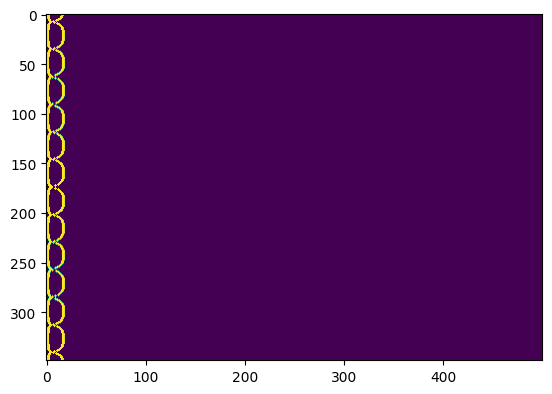

In [176]:
d3_array = np.zeros(shape=(resolution, resolution, resolution))

def update_d3_array(z, d3_array):
    for i in range(z.shape[0]-1):
        for j in range(z.shape[1]-1):
            if not np.isnan(z[i][j]):
                d3_array[i][j][int(z[i][j]*5)] =  1
                
# Update d3_array with each z array
update_d3_array(z1, d3_array)
update_d3_array(z12, d3_array)



def normalize_image(im, mult_factor = 1):
    '''
    Normalize image 0-1 and multiply by any factor
    '''
    norm_im = (im - im.min()) / (im.max()-im.min()) * mult_factor
    return norm_im



cell_write = './../ppujol/benchmarking/dome1.tif'
# d3_array = sk.morphology.binary_dilation(d3_array, footprint=sk.morphology.ball(2))
d3_array=d3_array.astype(np.uint8)

# Calculate the sum along axis  2
column_sums = np.sum(d3_array, axis=2)
d3_array_2 = np.transpose(d3_array, axes=(2, 1, 0))
# Find the indices of the columns that sum to zero
zero_sum_indices = np.where(column_sums[:,0] ==  0)

d3_array_2 = np.delete(d3_array, zero_sum_indices, axis=1)

zero_sum_indices = np.where(column_sums[0,:] ==  0)

d3_array_2 = np.delete(d3_array_2, zero_sum_indices, axis=0)


d3_array_2 = sk.morphology.binary_dilation(d3_array_2, footprint=sk.morphology.ball(1))
d3_array_2=d3_array_2.astype(np.uint8)


plt.imshow(d3_array_2[100])

In [177]:
d3_array_2 = np.transpose(d3_array_2, axes=(2, 1, 0))
d3_array_2 = d3_array_2[::-1, :, :]
d3_array_2 = d3_array_2[:, 7:-7, 8:-7]
d3_array_2.shape

(500, 335, 334)

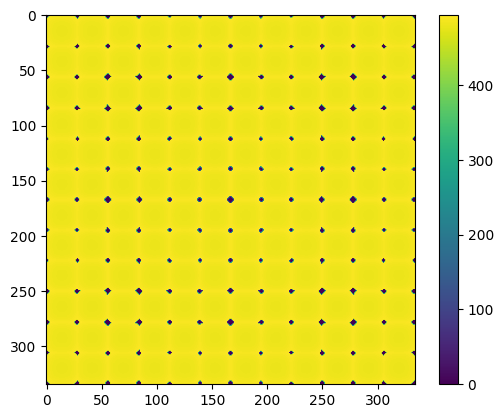

In [178]:
plt.imshow(np.argmax(d3_array_2, axis=0))
plt.colorbar()

(500, 335, 334)
(500, 334, 334)
(334, 334, 334)


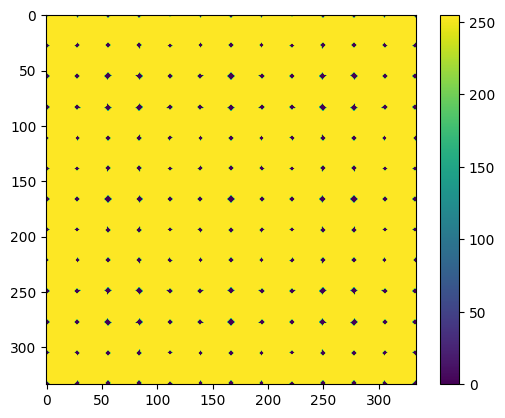

In [49]:
flat_monolayer = normalize_image(d3_array_2, 255).astype(np.uint8)
shape = flat_monolayer.shape
print(shape)
flat_monolayer = flat_monolayer[:, 1:, :] # Remove unwanted parts of the dome
shape = flat_monolayer.shape
print(shape)
dome_monolayer = np.zeros((shape[1], shape[1], shape[2]))
print(dome_monolayer.shape)
dome_monolayer[214:314, :, :] = flat_monolayer[400:500, :, :]
plt.imshow(np.max(dome_monolayer, axis=0))
plt.colorbar()

(500, 335, 334)
(500, 334, 334)
(334, 334, 334)


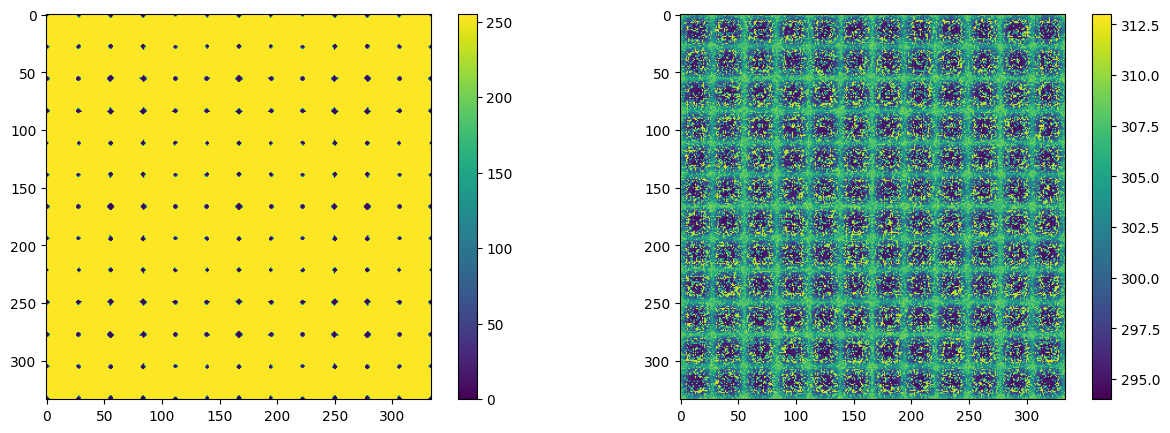

In [103]:
# flat_monolayer = sk.io.imread('./../ppujol/benchmarking/dome2_flat_intensities_variation.tif')

# flat_monolayer = np.flip(flat_monolayer, axis=0)
# flat_monolayer = normalize_image(flat_monolayer, 255).astype(np.uint8)

# shape = flat_monolayer.shape
# print(shape)
# # flat_monolayer = flat_monolayer[:, 1:, :] # Remove unwanted parts of the dome
# shape = flat_monolayer.shape
# print(shape)
# dome_monolayer = np.zeros((shape[1], shape[1], shape[2]))
# print(dome_monolayer.shape)
# dome_monolayer[214:314, :, :] = flat_monolayer[400:500, :, :]


flat_monolayer = normalize_image(d3_array_2, 255).astype(np.uint8)
shape = flat_monolayer.shape
print(shape)
flat_monolayer = flat_monolayer[:, 1:, :] # Remove unwanted parts of the dome
shape = flat_monolayer.shape
print(shape)
dome_monolayer = np.zeros((shape[1], shape[1], shape[2]))
print(dome_monolayer.shape)
dome_monolayer[214:314, :, :] = flat_monolayer[400:500, :, :]


plt.figure(figsize=(15,5))
plt.subplot(121)
plt.imshow(np.max(dome_monolayer, axis=0))
plt.colorbar()

displacement = np.zeros((3,5,5,5))

tp = 0

if tp == 0:
    displacement = displacement

if tp == 1:
    ### First displacement -- tp 1
    displacement[0, 2, 2, 2] = 50
    displacement[0, 2, :, 0] = 100
    displacement[0, 2, :, 4] = 100
    displacement[0, 2, 0, :] = 100
    displacement[0, 2, 4, :] = 100
    displacement[0, 4, 2, 2] = 200 # This value forces that the bottom of the dome is empty
    displacement[0, 4, 1:4, 1] = 50
    displacement[0, 4, 1:4, 3] = 50
    displacement[0, 4, 3, 2] = 50
    displacement[0, 4, 1, 2] = 50
    
if tp == 2:
    displacement[0, 4, 2, 2] = 100
    displacement[0, 3, 2, 2] = 100
    displacement[0, 3, 1:4, 1] = 20
    displacement[0, 3, 1:4, 3] = 20
    displacement[0, 3, 1, 2] = 20
    displacement[0, 3, 3, 2] = 20
    displacement[0, 2, :, 4] = 100
    displacement[0, 2, :, 0] = 100
    displacement[0, 2, 0, :] = 100
    displacement[0, 2, 4, :] = 100

if tp == 3:
    displacement[0, 2, 1:4, 1:4] = 30
    displacement[0, 2, 2, 2] = 100
    displacement[0, 3, 1:4, 1:4] = 60
    displacement[0, 3, 2, 2] = 200
    displacement[0, 4, 1:4, 1:4] = 10
    displacement[0, 4, 2, 2] = 0

if tp == 4:
    displacement[0, 2, 1:4, 1:4] = 30
    displacement[0, 2, 2, 2] = 100
    displacement[0, 3, 1:4, 1:4] = 60
    displacement[0, 3, 2, 2] = 200
    displacement[0, 4, 1:4, 1:4] = 10
    displacement[0, 4, 2, 2] = 0

    dome_monolayer = elasticdeform.deform_grid(dome_monolayer, displacement)

    displacement = np.zeros((3,5,5,5))

    displacement[0, 2, 2, 2] = -30
    displacement[0, 3, 1:4, 3] = -30
    
    displacement[1, 2, 1:4, 1] = 40
    displacement[1, 3, 1:4, 1] = -100

    
if tp == 5:
    displacement[0, 2, 1:4, 1:4] = 30
    displacement[0, 2, 2, 2] = 100
    displacement[0, 3, 1:4, 1:4] = 60
    displacement[0, 3, 2, 2] = 200
    displacement[0, 4, 1:4, 1:4] = 10
    displacement[0, 4, 2, 2] = 0

    dome_monolayer = elasticdeform.deform_grid(dome_monolayer, displacement)

    displacement = np.zeros((3,5,5,5))

    displacement[0, 2, 2, 2] = -30
    displacement[0, 3, 1:4, 3] = -30

    displacement[1, 2, 1:4, 1] = 40
    displacement[1, 3, 1:4, 1] = -100
    displacement[2, 2, 1:4, 1] = 40
    displacement[2, 3, 1:4, 1] = -100


if tp == 6:
    displacement[0, 2, 1:4, 1:4] = 30
    displacement[0, 2, 2, 2] = 100
    displacement[0, 3, 1:4, 1:4] = 60
    displacement[0, 3, 2, 2] = 200
    displacement[0, 4, 1:4, 1:4] = 10
    displacement[0, 4, 2, 2] = 0

    dome_monolayer = elasticdeform.deform_grid(dome_monolayer, displacement)

    displacement = np.zeros((3,5,5,5))

    displacement[0, 2, 2, 2] = -200
    displacement[0, 3, 2, 2] = -200
    displacement[0, 3, 1:4, 3] = -30
    displacement[0, 1:4, 1:4, 1:4] = -100

    displacement[1, 2, 1:4, 1] = 40
    displacement[1, 3, 1:4, 1] = -100
    
    displacement[2, 2, 1:4, 1] = 40
    displacement[2, 3, 1:4, 1] = -100
    
    

# print(displacement)
dome_monolayer_deformed = elasticdeform.deform_grid(dome_monolayer, displacement)

plt.subplot(122)
plt.imshow(np.argmax(dome_monolayer_deformed, axis=0))
# plt.imshow(dome_monolayer_deformed[290])
plt.colorbar()

In [104]:
## Functions

def get_r(image):
    image_r = np.transpose(image, axes=(1,0,2))
    return image_r

def get_top(image_r):
    image = np.transpose(image_r, axes=(1, 2, 0))
    image = np.rot90(image, axes=(1,2))
    return image

def normalize_image(im, mult_factor=1):
    '''
    Normalize image 0-1 and multiply by any factor
    '''
    norm_im = (im - im.min()) / (im.max()-im.min()) * mult_factor
    return norm_im

def amplify_image(real_im, fake_im):
    amplifications = [real_im.shape[i]/fake_im.shape[i] for i in range(len(real_im.shape))]
    fake_im = zoom(fake_im, (max(amplifications), max(amplifications), max(amplifications)), order=1)
    return fake_im

def realistic_brightness_and_contrast(fake_im, real_im):
    fake_im_modified = normalize_image(fake_im, real_im.max())
    fake_im_modified = np.clip(fake_im_modified.astype(int) - (fake_im_modified.mean()-real_im.mean()), 0, 65535).astype(np.uint16) # adjust brightness
    fake_im_modified = np.clip((fake_im_modified - fake_im_modified.mean()) * real_im.std()/fake_im_modified.std() + fake_im_modified.mean(), 0, 65535).astype(np.uint16) # adjust contrast
    return fake_im_modified

def random_noise(image, sum_to_noise=14):
    image_noise = copy(image)+np.random.normal(0, 2, image.shape)+sum_to_noise
    return image_noise

def blur(image, norm_top=10000):
    fake_im_modified = image.astype(np.float64)
    image_gaussian = gaussian_filter(image, 2)
    # fake_im_modified_blur = normalize_image(fake_im_modified_blur, 65535).astype(np.uint16)
    image_gaussian = normalize_image(image_gaussian, norm_top).astype(np.uint16)
    return image_gaussian

def movement_blur(image, size=15):
    image_r = get_r(image)
    kernel_z = np.zeros((size, size))
    kernel_z[:, 2] = 1
    kernel_z = kernel_z/kernel_z.sum()
    
    image_movement_r = np.zeros_like(image_r)
    for i in range(image_r.shape[0]):
        slice_movement_r = image_r[i]
        slice_movement_r = cv2.filter2D(slice_movement_r, -1, kernel_z)
        image_movement_r[i] = slice_movement_r

    image_movement = get_top(image_movement_r)
    return image_movement

def salt_and_pepper_noise(image, salt_ratio=0.05, pepper_ratio=0.05):
    z, y, x = image.shape
    salt = np.random.rand(z, y, x) < salt_ratio
    pepper = np.random.rand(z, y, x) < pepper_ratio
    noisy_image = np.copy(image)
    noisy_image[salt] = image.mean()
    noisy_image[pepper] = 0
    return noisy_image

def black_45(image, real_image):
    image_r = get_r(image)
    real_image_r = get_r(real_im) 

    non_zero = np.sum(real_image_r, axis=0)
    black_white_r = np.zeros((real_image_r.shape))
    black_white_r[:, non_zero != 0] = 1

    ## Second axis _r
    amplification = image_r.shape[1]/black_white_r.shape[1]
    black_white_r = zoom(black_white_r, (amplification, amplification, amplification), order=1)
    
    ## Third axis _r
    middle_index = black_white_r.shape[2]//2-25
    while (image_r.shape[2] < black_white_r.shape[2]):
        black_white_r = np.concatenate((black_white_r[:, :, :middle_index], black_white_r[:, :, middle_index+50:]), axis=2) ## Remove slices
    
    while (image_r.shape[2] > black_white_r.shape[2]):
        number_slices = image_r.shape[2]-black_white_r.shape[2]
        slice_of_ones = np.ones((black_white_r.shape[0], black_white_r.shape[1], number_slices))
        black_white_r = np.concatenate((black_white_r[:, :, :middle_index], slice_of_ones, black_white_r[:, :, middle_index:]), axis=2) ## Add slices
    
    ##  First axis _r
    middle_index = black_white_r.shape[0]//2-25
    while (image_r.shape[0] < black_white_r.shape[0]):
        black_white_r = np.concatenate((black_white_r[:middle_index, :, :], black_white_r[middle_index+50:, :, :]), axis=0) ## Remove slices
    
    while (image_r.shape[0] > black_white_r.shape[0]):
        number_slices = image_r.shape[0]-black_white_r.shape[0]
        shaped_slices = black_white_r[middle_index, ...]
        shaped_slices = np.expand_dims(shaped_slices, axis=0)
        shaped_slices = np.repeat(shaped_slices, number_slices, axis=0)
        black_white_r = np.concatenate((black_white_r[:middle_index, :, :], shaped_slices, black_white_r[middle_index:, :, :]), axis=0) ## Add slices
    
    return get_top(black_white_r*image_r)

def plotcomparisons(real_im, fake_im, slice_r=300, slice_top=200):
    plt.figure(figsize=(15, 12))
    plt.subplot(221)
    plt.imshow(get_r(real_im)[slice_r])
    plt.colorbar()
    plt.subplot(222)
    plt.imshow(get_r(fake_im)[slice_r])
    plt.colorbar()
    
    plt.subplot(223)
    plt.imshow(real_im[slice_top])
    plt.colorbar()
    plt.subplot(224)
    plt.imshow(fake_im[slice_top])
    plt.colorbar()

    pass

def valuecomparisons(real_im, fake_im):
    print(f"Shape of the real image = {real_im.shape}")
    print(f"Shape of the fake image = {fake_im.shape}")
    
    print(f"Max intensity of the real image = {real_im.max()}")
    print(f"Max intensity of the fake image = {fake_im.max()}")
    
    print(f"Min intensity of the real image = {real_im.min()}")
    print(f"Min intensity of the fake image = {fake_im.min()}")
    
    print(f"Brightness - Mean intensity of the real image = {real_im.mean()}")
    print(f"Brightness - Mean intensity of the fake image = {fake_im.mean()}")
    
    print(f"Contrast - Std intensity of the real image = {real_im.std()}")
    print(f"Contrast - Std intensity of the fake image = {fake_im.std()}")

    pass

In [105]:
tp = str(tp)
fake_im = copy(dome_monolayer_deformed)
real_im = sk.io.imread('./../ppujol/NiceDomes/62.tif')
real_im = real_im[0]

real_im_r = get_r(real_im)
fake_im_r = get_r(fake_im)

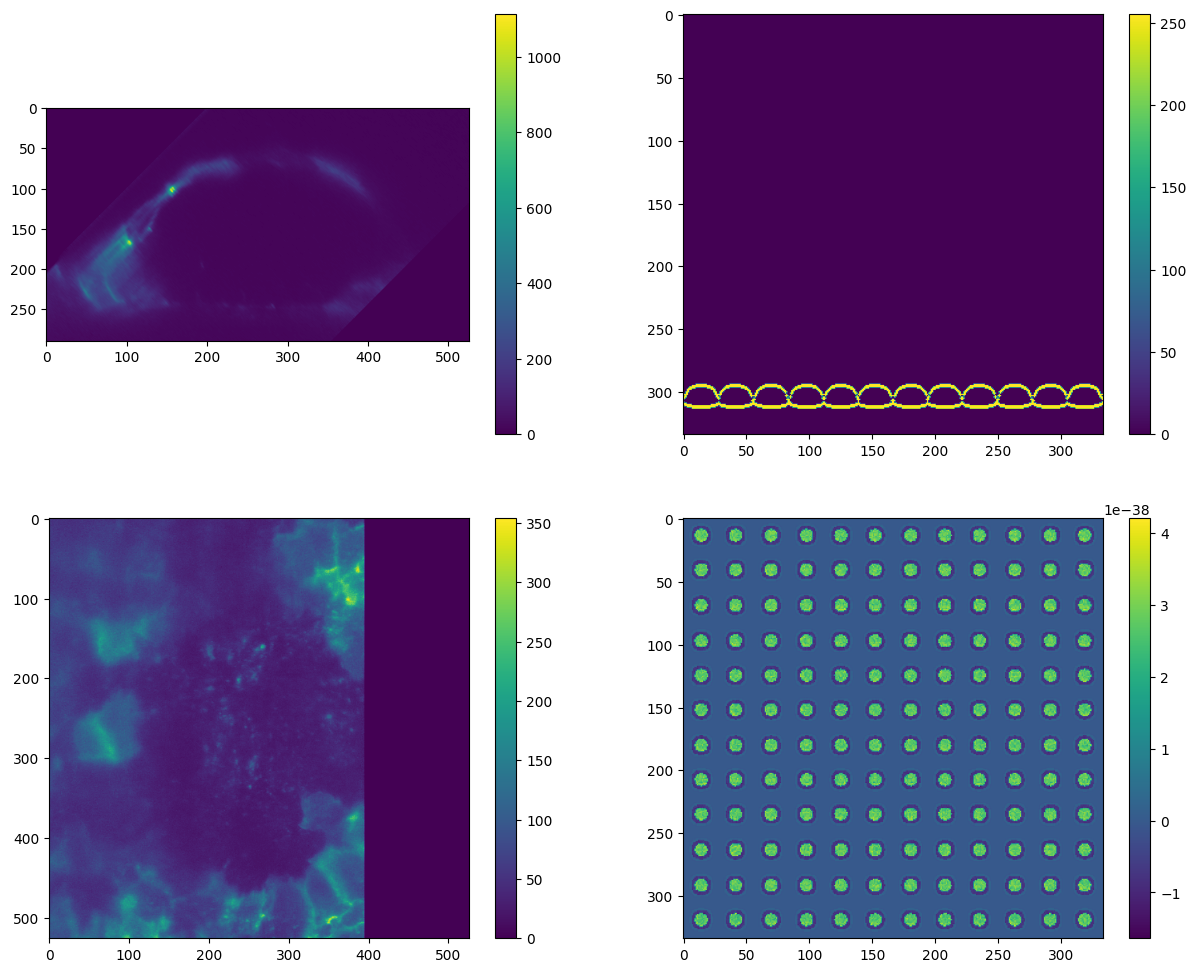

In [106]:
plotcomparisons(real_im, fake_im, slice_r=150, slice_top=250)

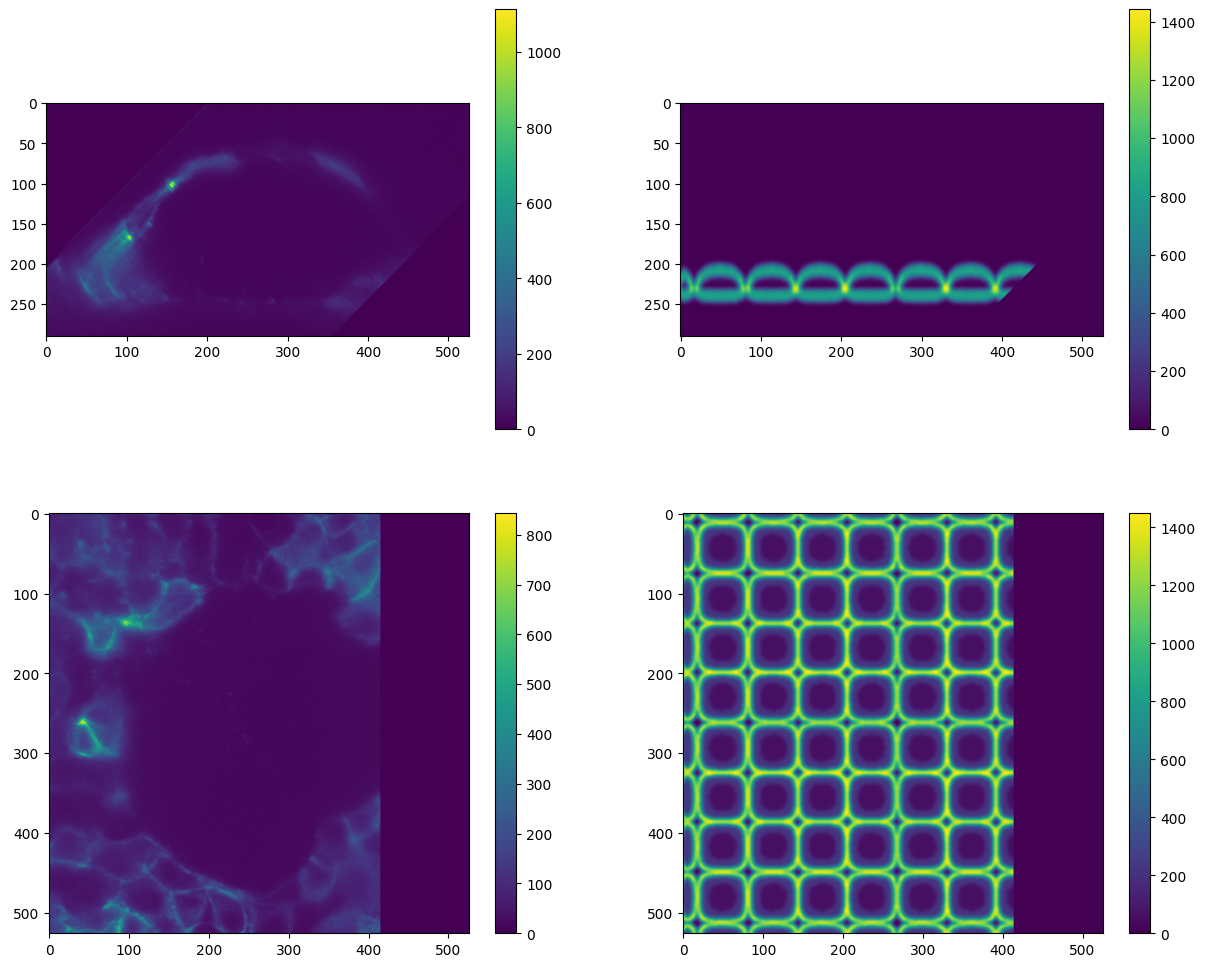

In [109]:
fake_im_cut = copy(fake_im)
fake_im_cut = realistic_brightness_and_contrast(fake_im_cut, real_im)
# valuecomparisons(real_im, fake_im_cut)

if tp == '0':
    fake_im_cut = fake_im_cut[205:, 50:284, 50:284] ## Image of """tp0"""
if tp == '1':
    fake_im_cut = fake_im_cut[205:, 50:284, 50:284] ## Image of """tp1"""
if tp == '2':
    fake_im_cut = fake_im_cut[205:, 50:284, 50:284] ## This is the cut to have the same size as the original image of """tp2"""
if tp == '3':
    fake_im_cut = fake_im_cut[160:, 20:304, 20:304] ## Image of """tp3"""
if tp == '4':
    fake_im_cut = fake_im_cut[180:, 20:314, 20:314] ## Image of """tp4"""
if tp == '5':
    fake_im_cut = fake_im_cut[180:, 20:314, 20:314] ## Image of """tp5"""
if tp == '6':
    fake_im_cut = fake_im_cut[205:, 50:284, 50:284] ## Image of """tp6"""

fake_im_cut = amplify_image(real_im, fake_im_cut)
fake_im_cut = blur(fake_im_cut, norm_top=real_im.max())
fake_im_cut = movement_blur(fake_im_cut, size=15)

# fake_im_cut = random_noise(fake_im_cut)
# fake_im_cut = salt_and_pepper_noise(fake_im_cut, salt_ratio=0.005, pepper_ratio=0.005)
fake_im_cut = black_45(fake_im_cut, real_im)

if tp == '3':
    fake_im_cut = fake_im_cut[20:320, :, :] ## Final cut of """tp3"""

plotcomparisons(real_im, fake_im_cut, slice_r=150, slice_top=230)


In [110]:
tiff.imwrite('./../ppujol/benchmarking/dome2_original_tp'+tp+'.tif', fake_im_cut.astype(np.uint16), imagej=True)



